## Breast Cancer Detection using various Machine Learning models

### Import Needed Libraries and Packages 

In [1]:
# importing various libraries needed 
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


# import libraries needed for ML models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, roc_auc_score #  ,plot_confusion_matrix,
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, balanced_accuracy_score


In [2]:
import warnings
warnings.filterwarnings('ignore')

### User Defined Functions needed to use repetively when comparing the metrics for each model

In [3]:
# Function to return the accuracy metrics
def get_accuracy(X_train, X_test, y_train, y_test, model):
    return  {"test Accuracy":metrics.accuracy_score(y_test, model.predict(X_test)),
             "train Accuracy": metrics.accuracy_score(y_train, model.predict(X_train))}

# Function to calculate the average correlation between predictors
def get_correlation(X_test, y_test,models):
    n_estimators=len(models.estimators_)
    prediction=np.zeros((y_test.shape[0],n_estimators))
    predictions=pd.DataFrame({'estimator '+str(n+1):[] for n in range(n_estimators)})
    
    for key,model in zip(predictions.keys(),models.estimators_):
        predictions[key]=model.predict(X_test.to_numpy())
    
    corr=predictions.corr()
    print("Average correlation between predictors: ", corr.mean().mean()-1/n_estimators)
    return corr

# Function to determine the error between the predicted and the test target
def evaluate_metrics(model_name, yt, yp):
    results_pos = {}
    results_pos['model_name'] = model_name
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp)
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

# Function to determine the Accuracy for the Train and Test data
#def get_accuracy(X_train, X_test, y_train, y_test, model):
#    return  {"test Accuracy":metrics.accuracy_score(y_test, model.predict(X_test)),"train Accuracy": metrics.accuracy_score(y_train, model.predict(X_train))}

### Load the dataset of results of the FNA of masses 

In [4]:
df = pd.read_csv('data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


### Brief Exploratory Data Analysis

In [5]:
df.shape

(569, 33)

The dataset has 569 rows and 33 columns

In [6]:
# Check for columns with null entries
df.columns[df.isna().any()]

Index(['Unnamed: 32'], dtype='object')

In [7]:
df['Unnamed: 32'].isna().sum()

569

Since 'Unnamed: 32' column has only null values, we will drop the column

In [8]:
df = df.drop('Unnamed: 32', axis=1)

#### Now that we have 32 features (columns), lets review the data types of the columns

In [9]:
# Group Columns by Data type
grouped = df.columns.to_series().groupby(df.dtypes).groups

for dtype, columns in grouped.items():
    print(f"Columns with {dtype} data type: {', '.join(columns)}")

Columns with int64 data type: id
Columns with float64 data type: radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, concave points_se, symmetry_se, fractal_dimension_se, radius_worst, texture_worst, perimeter_worst, area_worst, smoothness_worst, compactness_worst, concavity_worst, concave points_worst, symmetry_worst, fractal_dimension_worst
Columns with object data type: diagnosis


Since the *diagnosis* column is the only non-numeric column, and *diagnosis* is more than likely the target column, lets view the entries.

In [10]:
df.diagnosis.value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

Convert the diagnosis entries from B for Benign to 0 and M for Malignant to 1 and create the target variable, y

In [11]:
df['diagnosis'] = df['diagnosis'].map({'B': 0, 'M': 1})
df['diagnosis'].value_counts()
y = df['diagnosis'].astype('int')

Since the vast majority of the columns are numeric, lets look at the stats for each column

In [12]:
df.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


The numeric features vary in range and spread. We will more than likely perform a scaling of the data.

<Axes: >

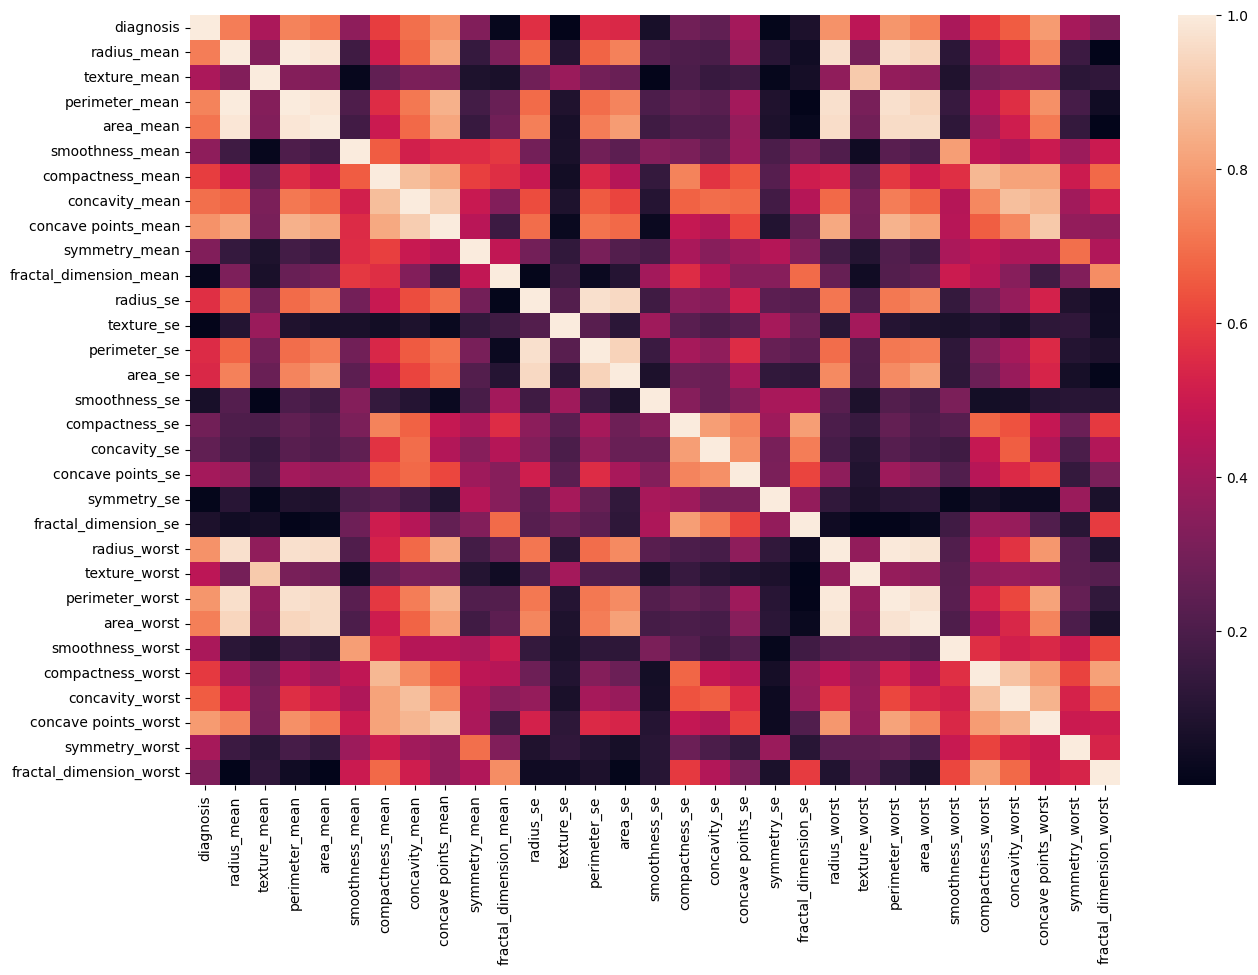

In [13]:
# Review the correlation Matrix to view any any highly correlated (~1) features
correlation_matrix = df.iloc[1:, 1:].corr().abs() #  ignore the Id column 
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(correlation_matrix) 

Observations: 
- The columns involving perimeter and area are highly correlated features to each other and to the diagnosis column.
- Least correlation between diagnosis are the *fractal dimension*, *texture*, *smoothness*, and *symmetry* columns. 

#### Identify the features strongly corrleated with the diagnosis (target) column.

In [14]:
threshold = 0.70 # minimum correlation value to be considered strongly correlated
highly_correlated = (correlation_matrix.iloc[:,0] >= threshold) & (correlation_matrix.iloc[:,0] < 1.0)


### Get indices of strongly correlated columns
highly_correlated_indices = highly_correlated[highly_correlated].index.tolist()


print("Highly correlated columns: {}".format(len(highly_correlated_indices)))
print(highly_correlated_indices)


Highly correlated columns: 8
['radius_mean', 'perimeter_mean', 'area_mean', 'concave points_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 'concave points_worst']


### Data Pre-Processing

Since we already have our target column (*diagnosis*) as *y*, lets create our features dataframe, X. 

In [15]:
# Case I: with all of the features
X = df.drop(['id', 'diagnosis'],axis=1)

# Case II, with only the mean features
X_mean = df[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]

# Case III: with only the highly correlated mean features
X_corr = df[highly_correlated_indices]


## Split the Dataset into Training and Testing sets

In [16]:
# Split 80% as training dataset
# and 20% as testing dataset in a stratified manner 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 11)

Now lets scale the train and test features values.

In [17]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

# Case 1
X_mean_train = X_train[:,[0,9]]
X_mean_test = X_test[:,[0,9]]

# Case 2
#X_corr_train = X_train[highly_correlated_indices]
#X_corr_test = X_test[highly_correlated_indices]

## Comparing different ML Models (Logistic Regression, KNN, SVC, RandomForest) to determine best model
#### Defining functions to set the hyperparameters to tune for the GridSearch for each model so that we can obtain the best parameters to use to fit the model to the data


In [18]:
rs = 145 # Ramdom State variable
# Grid search hyperparameters for a logistic regression model
def grid_search_lr(X_train, y_train):
    params_grid = {
    'class_weight': [{0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}],
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'max_iter':[100, 500, 1000, 10000]
    }
    lr_model = LogisticRegression(random_state=rs, max_iter=1000)
    grid_search = GridSearchCV(estimator = lr_model, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

# Grid search hyperparameters for a KNN model
def grid_search_knn(X_train, y_train):
    params_grid = {
    'n_neighbors': [3, 5, 7, 9],        # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weighting strategy
    'p': [1, 2]                          # Power parameter for Minkowski distance
    }
    knn_model = KNeighborsClassifier(n_neighbors=2)
    grid_search = GridSearchCV(estimator = knn_model, 
                           param_grid = params_grid, 
                           cv = 5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params
        
# Grid search hyperparameters for a SVM model
def grid_search_svm(X_train, y_train):
    params_grid = {
    'C': [1, 10, 100],
    'kernel': ['poly', 'rbf', 'sigmoid']
    }
    svm_model = SVC()
    # Define a GridSearchCV to search the best parameters
    grid_search = GridSearchCV(estimator = svm_model, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 5, verbose = 1)
    # Search the best parameters with training data
    grid_search.fit(X_train, y_train.values.ravel())
    best_params = grid_search.best_params_
    return best_params

# Grid search hyperparameters for a random forest model
def grid_search_rf(X_train, y_train):
    params_grid = {
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [25, 50, 100],
    'min_samples_split': [2, 5],
    'class_weight': [{0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}]
    }
    rf_model = RandomForestClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator = rf_model, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params



## Logistic Regression tuning and best fit model

In [19]:
# Determine the best hyperparameters to use for Logistic Regression for the data
lr_best_params = grid_search_lr(X_train, y_train)
lr_best_params

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


{'C': 10,
 'class_weight': {0: 0.2, 1: 0.8},
 'max_iter': 100,
 'penalty': 'l1',
 'solver': 'saga'}

In [20]:
lr_best_params['C']

10

In [21]:
# Train, fit and test the model with the best parameters
class_weights = {0: 0.05, 1: 0.95}
l2_model = LogisticRegression( C=lr_best_params['C'], 
                            class_weight=lr_best_params['class_weight'], 
                            max_iter=lr_best_params['max_iter'], 
                            penalty=lr_best_params['penalty'], 
                            solver=lr_best_params['solver'])
l2_model.fit(X_train, y_train)
l2_preds = l2_model.predict(X_test)

In [22]:
evaluate_metrics('Logistic Regression', y_test, l2_preds)

{'model_name': 'Logistic Regression',
 'accuracy': 0.9736842105263158,
 'recall': array([0.95833333, 1.        ]),
 'precision': array([1.        , 0.93333333]),
 'f1score': array([0.9787234 , 0.96551724])}

## K Nearest Neighbors tuning and best fit model

In [23]:
# Determine the best hyperparameters to use for the k-Nearest Neighbors for the data
knn_best_params = grid_search_knn(X_train, y_train)
knn_best_params

{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}

In [24]:
# Define a KNN classifier with the hypertuned parameters
knn_model = KNeighborsClassifier(n_neighbors=knn_best_params['n_neighbors'], 
                                p=knn_best_params['p'], 
                                weights=knn_best_params['weights'])
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)

In [25]:
evaluate_metrics('k-Nearest Neighbors', y_test, knn_preds)

{'model_name': 'k-Nearest Neighbors',
 'accuracy': 0.9649122807017544,
 'recall': array([1.       , 0.9047619]),
 'precision': array([0.94736842, 1.        ]),
 'f1score': array([0.97297297, 0.95      ])}

## Single Vector Machine tuning and best fit model

In [26]:
# Determine the best hyperparameters to use for the SVM model for the data
svm_best_params = grid_search_svm(X_train, y_train)
svm_best_params

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'C': 1, 'kernel': 'rbf'}

In [27]:
# Define a SVM classifier with the hypertuned parameters
svm_model = SVC(C=svm_best_params['C'] , kernel=svm_best_params['kernel'])
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

In [28]:
evaluate_metrics('SVM', y_test, svm_preds)

{'model_name': 'SVM',
 'accuracy': 0.9736842105263158,
 'recall': array([0.98611111, 0.95238095]),
 'precision': array([0.97260274, 0.97560976]),
 'f1score': array([0.97931034, 0.96385542])}

## Random Forest tuning and best fit model

In [29]:
# Determine the best hyperparameters to use for the Random Formest for the data
rf_best_params = grid_search_rf(X_train, y_train)
rf_best_params

Fitting 5 folds for each of 72 candidates, totalling 360 fits


{'class_weight': {0: 0.3, 1: 0.7},
 'max_depth': 10,
 'min_samples_split': 5,
 'n_estimators': 50}

In [30]:
## Random Forest Model
class_weights={0: 0.05, 1: 0.95}
rf_model = RandomForestClassifier( class_weight=rf_best_params['class_weight'], 
                                max_depth = rf_best_params['max_depth'], 
                                min_samples_split=rf_best_params['min_samples_split'], 
                                n_estimators=rf_best_params['n_estimators'])
rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight={0: 0.3, 1: 0.7}, max_depth=10,
                       min_samples_split=5, n_estimators=50)

In [31]:
print(get_accuracy(X_train, X_test, y_train, y_test, rf_model))

{'test Accuracy': 0.9736842105263158, 'train Accuracy': 0.9956043956043956}


## Comparison of accuracy metrics

In [33]:
comparison_metrics = [ evaluate_metrics('Logistic Regression', y_test, l2_preds), 
                    evaluate_metrics('k-Nearest Neighbors', y_test, knn_preds),
                    evaluate_metrics('SVM', y_test, svm_preds)]

df_metrics = pd.DataFrame(comparison_metrics)
df_metrics

,model_name,accuracy,recall,precision,f1score
0,Logistic Regression,0.973684,"[0.9583333333333334, 1.0]","[1.0, 0.9333333333333333]","[0.9787234042553191, 0.9655172413793104]"
1,k-Nearest Neighbors,0.964912,"[1.0, 0.9047619047619048]","[0.9473684210526315, 1.0]","[0.972972972972973, 0.9500000000000001]"
2,SVM,0.973684,"[0.9861111111111112, 0.9523809523809523]","[0.9726027397260274, 0.975609756097561]","[0.9793103448275863, 0.963855421686747]"
